In [2]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd,grad,value_and_grad
from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'cpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

0.4.24
3.12.1
1.12.0


/tmp/ipykernel_2124363/734137169.py:27: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
n_col =40
n_row = n_col
x_span = 6
y_span = 6

# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)
#zs =  0.2*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)

zs =  0.1*(-(xs-x_span/2)**2+(x_span/2)**2
          -(ys-x_span/2)**2+(x_span/2)**2)

'''zs = np.tile(zs,n_row+1)
zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)'''
'''zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
zs = np.where(ys==0,0,zs)
zs = np.where(ys==y_span,0,zs)
'''

# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.015
E = 2e10
nu = 0.3
design_nodes = []
non_design_nodes = []
loading_nodes = []
for i in range(n_node):
    if [xs[i],ys[i]]!= [0,0] and [xs[i],ys[i]] != [0,y_span] and [xs[i],ys[i]] != [x_span,y_span] and [xs[i],ys[i]] != [x_span,0]:
        design_nodes.append(i)
    else:
        non_design_nodes.append(i)
    if [xs[i],ys[i]]==[x_span/2,0] or [xs[i],ys[i]]==[x_span/2,y_span] or [xs[i],ys[i]]==[0,y_span/2] or [xs[i],ys[i]]==[x_span,y_span/2]:
        loading_nodes.append(i)
            
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500

In [4]:
loading_nodes

[20, 820, 860, 1660]

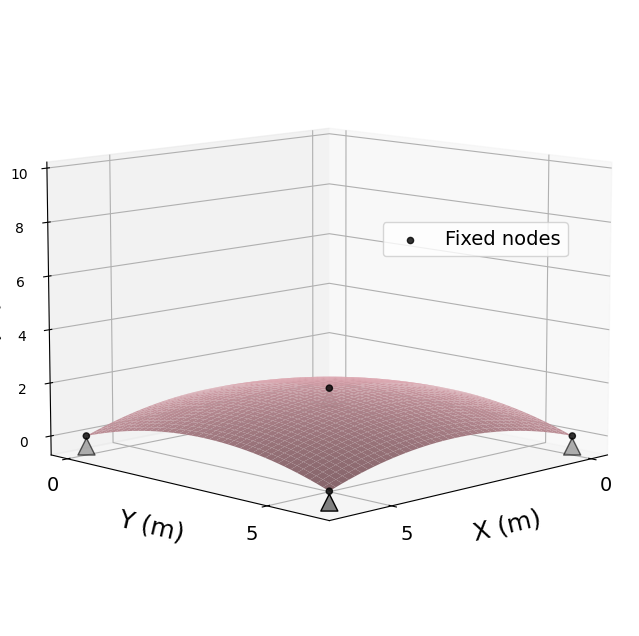

In [5]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

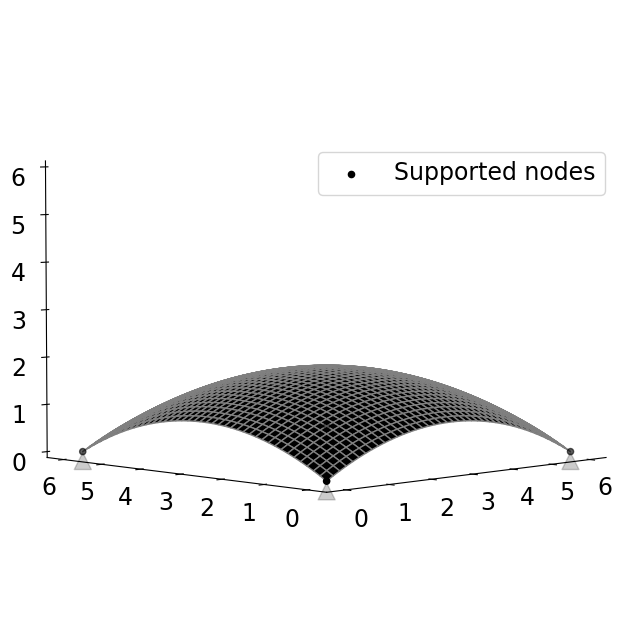

In [15]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(1)
tdco.set_facecolor('black')
tdco.set_edgecolor('grey')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(4, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [17]:
np.max(zs)

1.8

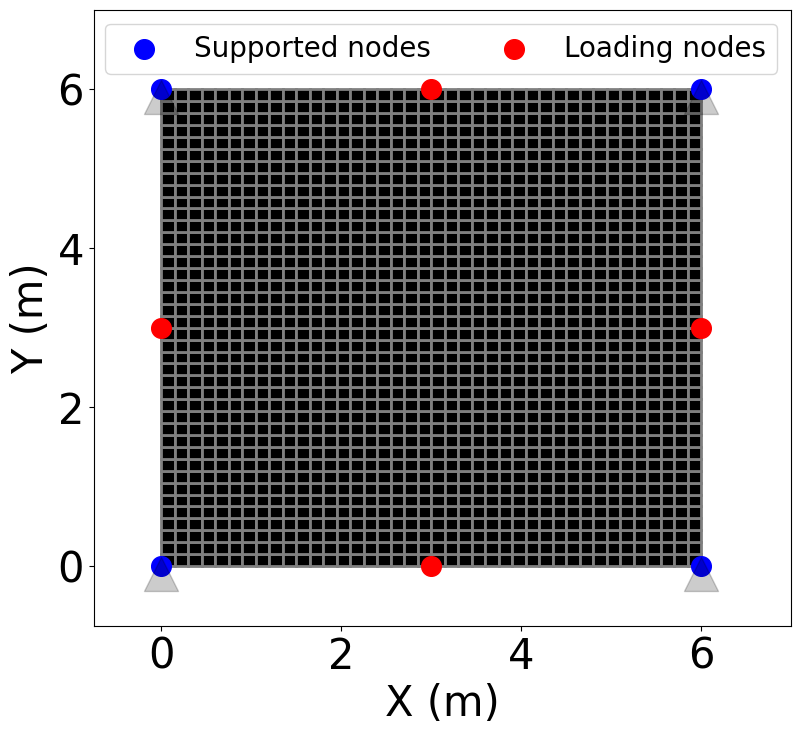

In [9]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(1)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[loading_nodes],ys[loading_nodes],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [88]:
# Inputs of NN
# Embed some info
# 1. X,Y COORDINATES
# 2. Distance to the boundary: how close they are to the boundary
# 3. Centrality
from jax import vmap
def dis_boundary(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the minimum distance of each node to the boundary node
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    return jnp.min(vmap_norm(crd_xy,bound_xy),axis=1)

def v_centrality(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the vertex centrality. Normalized so that minimum is "1".
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    
    norm_min =jnp.min(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))
    norm_max = jnp.max(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))
    return (jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1)-norm_min)/(norm_max-norm_min)

In [89]:
dis_b = dis_boundary(xs,ys,non_design_nodes)[design_nodes]
v_cen = v_centrality(xs,ys,non_design_nodes)

In [90]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))

r = 0.05 #Radius

Mapping for nodal distance filter

In [91]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,r)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [92]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

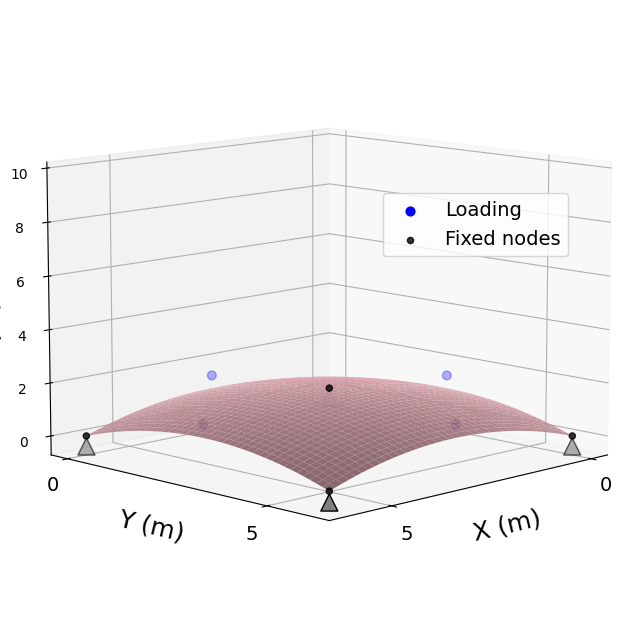

In [93]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs_filtered.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[loading_nodes],ys[loading_nodes],zs_filtered[loading_nodes]+0.5,color='blue',label='Loading',s=40)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

Mapping for shell-center distance filter

In [94]:
xs_shell = np.average(xs[cnct],axis=1)
ys_shell = np.average(ys[cnct],axis=1)

In [95]:
#Matrix storing XY-projected distance  
dx_ij_shell = xs_shell[:,None]-xs_shell[None,:]
dy_ij_shell = ys_shell[:,None]-ys_shell[None,:]
D_ij_shell = (dx_ij_shell**2 + dy_ij_shell**2)**0.5

#Create the filter mapping matrix
B_ij_ini_shell = Linear_filter(D_ij_shell,0.25)
B_ij_sum_shell = np.sum(B_ij_ini_shell,axis=1)
B_ij_sum_shell = B_ij_sum_shell.repeat(xs_shell.shape[0]).reshape(xs_shell.shape[0],xs_shell.shape[0])
B_ij_shell = B_ij_ini_shell/B_ij_sum_shell

In [96]:
B_ij_shell.shape

(1600, 1600)

In [97]:
#W(A): total volume
def coeff_E(mu,p=8):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**p*E

def coeff_E2(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**2*E


def og_p(p_norm):
    '''
    Return the un-normalized p
    '''
    p_max = 3
    p_min = 0
    return (p_max-p_min)*p_norm+p_min

def norm_p(p):
    p_max = 3
    p_min = 0
    return  (p-p_min)/(p_max-p_min)


def plt_plan(mu_opt_filtered,i=0):
    fig,ax = plt.subplots(figsize=(11,10))
    ax.set_ylim(-2,8)
    ax.set_xlim(-2,8)
    #plt.title('{}-th iteration'.format(i))
    plt.xlabel('X (m)',fontsize=30)
    plt.ylabel('Y (m)',fontsize=30)
    #ax = fig.add_subplot#(projection='3d')
    #ax.set_zlim(0,20)
    #ax.set_xlabel('X (m)',fontsize=15)
    #ax.set_ylabel('Y (m)',fontsize=15)
    #ax.set_zlabel('Z (m)',fontsize=15)
    all_corners= []
    import matplotlib as mpl
    cmap = mpl.colormaps['binary']
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
        alpha = float(mu_opt_filtered[i])
        #cthis_poly.set_alpha(alpha)
        this_poly.set_facecolor(cmap(alpha))
        this_poly.set_edgecolor('black')
        this_poly.set_lw(2)
        ax.add_patch(this_poly)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #Plot a basic wireframe.
    #for i in range(n_ele_bar):
    ##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


    cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20)# loc=(0.5,0.7))
    ax.grid(False)
    plt.show()

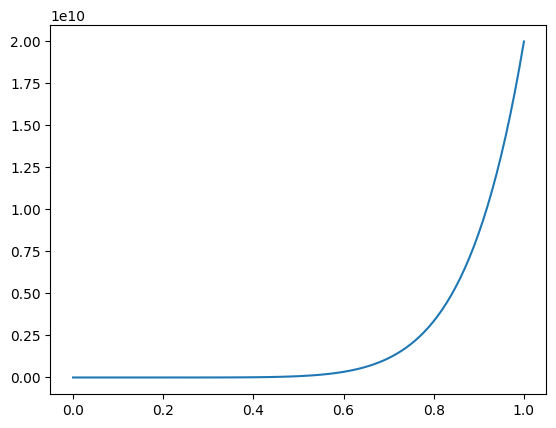

In [98]:
plt.plot(np.linspace(0,1,100),coeff_E(np.linspace(0,1,100)))

In [99]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i in non_design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    if i in loading_nodes:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()




In [100]:
model.solve()

In [101]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model

#Element parameter: 
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 1) # element object, quad's young's modulus
    sso_model.add_eleparameter(eleparameter)


#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

# NN

1. Input of NN: 
* XY of nodes

2. Outoput:
* Z
* Density ?


In [102]:
import pymesh
from flax import linen as nn

In [103]:
class SimpleNN(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons
    num_layers: int #Number of hidden layers

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        for i in range(self.num_layers):
            x = nn.Dense(features=self.num_hidden)(x)
            #x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        x = nn.sigmoid(x) #Between 0 and 1
        return x

In [132]:
n_input = 2 #(X,Y) of each node
n_hidden = 40 # neurons
n_out = 1 #Z of each node & density
n_layers =3 #number of hidden layers

rng = jax.random.PRNGKey(42)

inp = np.array([(xs-x_span/2)/np.max(xs),(ys-y_span/2)/np.max(ys)]).T#np.array([v_cen]).T#,
#rng, inp_rng, init_rng = jax.random.split(rng, 3)

In [133]:
NN = SimpleNN(n_hidden,n_out,n_layers)

In [134]:
rng, init_rng = jax.random.split(rng, 2)
# Initialize the model
params = NN.init(init_rng, inp)

In [135]:
import optax
optimizer = optax.adam(learning_rate=0.01)

In [136]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=NN.apply,
                                            params=params,
                                            tx=optimizer)

In [137]:
model_state.apply_fn(params, inp).shape

(1681, 1)

In [138]:
def calculate_loss(state, params, inp, alpha=0.1, p=2):


    ##Apply_fn: ML input to output
    outs = state.apply_fn(params, inp) #shape (n_node,2)
    node_rho_params = outs.reshape(-1)
    
    
    #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.
    
    #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
    ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
    filtered_mu = B_ij_shell@ele_params
    E_step = coeff_E(filtered_mu,p) #Penalized Young's modulus
    #sso_model.update_eleparameter(E_step) # Update the model
    
    #3. Loss function: penalized compliance
    parameter_values = E_step
    compliance = sso_model.helper_params_to_objective(parameter_values,which_solver='sparse',enforce_scipy_sparse=True)
    # loss = compliance (normalized) + alpha *(volume/exp_volume -1)^2
    loss1 = compliance/40
    loss2 = alpha*(jnp.sum(filtered_mu)/(0.5*sso_model.eleparameters_values.shape[0])-1)**2
    loss =  loss1 + loss2
    
    return loss#loss1,loss2,z,filtered_mu

In [139]:
calculate_loss(model_state,params,inp)

Array(0.72715985, dtype=float64)

In [140]:
grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
loss, grads = grad_fn(model_state, model_state.params, inp)

In [141]:
@jax.jit  # Jit the function for efficiency
def train_step(state, inp,alpha=0.1, p=2):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, inp,alpha, p)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [59]:
%timeit train_step(model_state, inp)

1.38 s ± 8.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [142]:
metrics_history = {'train_loss': []}
from tqdm import tqdm
loss_list =[]
def train_model(state, num_epochs=200):
    alpha = 0.1
    p = 2
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        if alpha < 100:
            alpha = 0.1 +len(loss_list) * 0.05
        if p<8:
            p = 7.5#2 + 0.06*len(loss_list)
        state, loss = train_step(state, inp,alpha,p)
        metrics_history['train_loss'].append(loss)
        print('Train epoch {}'.format(len(metrics_history['train_loss'])+1)+'  ,loss:{}'.format(loss))
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        # For simplicity, we skip this part here
        loss_list.append(loss)
        if len(loss_list)%5==0:
            i = len(loss_list)
            
            outs = state.apply_fn(state.params, inp) #shape (n_node,2)
            node_params = outs[:,0]
            node_rho_params = outs[:,1]



            #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.

            #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
            ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
            filtered_mu = B_ij_shell@ele_params
            E_step = coeff_E(filtered_mu) #Penalized Young's modulus
            print(jnp.sum(ele_params))
            
            plt_plan(filtered_mu,i)
    return state

  0%|          | 1/205 [00:11<39:40, 11.67s/it]

Train epoch 2  ,loss:13.825722268866667


  1%|          | 2/205 [00:13<19:00,  5.62s/it]

Train epoch 3  ,loss:4.9408112971548315


  1%|▏         | 3/205 [00:14<12:23,  3.68s/it]

Train epoch 4  ,loss:2.259998523642684


  2%|▏         | 4/205 [00:15<09:17,  2.77s/it]

Train epoch 5  ,loss:1.270939164807083
Train epoch 6  ,loss:0.8522327376855993
1264.280550070986


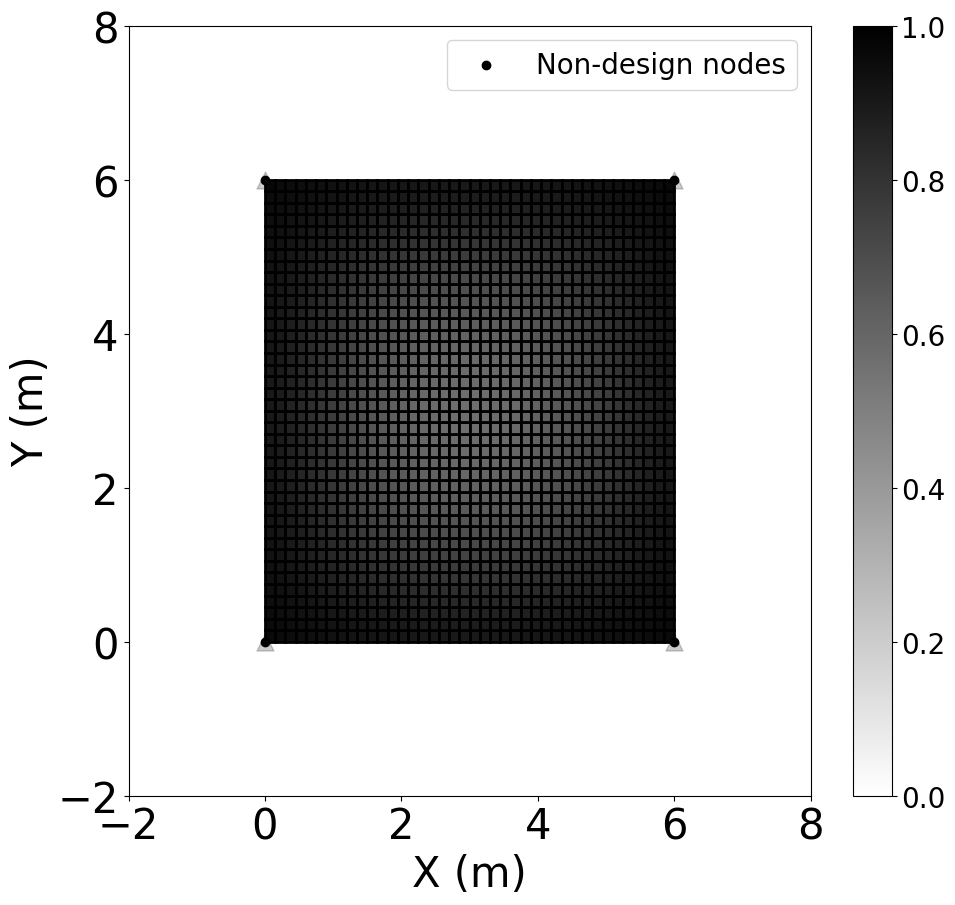

  3%|▎         | 6/205 [00:19<07:38,  2.30s/it]

Train epoch 7  ,loss:0.6765321671977527


  3%|▎         | 7/205 [00:21<06:36,  2.00s/it]

Train epoch 8  ,loss:0.6093586063342897


  4%|▍         | 8/205 [00:22<05:56,  1.81s/it]

Train epoch 9  ,loss:0.5938806141797563


  4%|▍         | 9/205 [00:24<05:28,  1.68s/it]

Train epoch 10  ,loss:0.606014099464988
Train epoch 11  ,loss:0.6329826603189453
1427.2689376117582


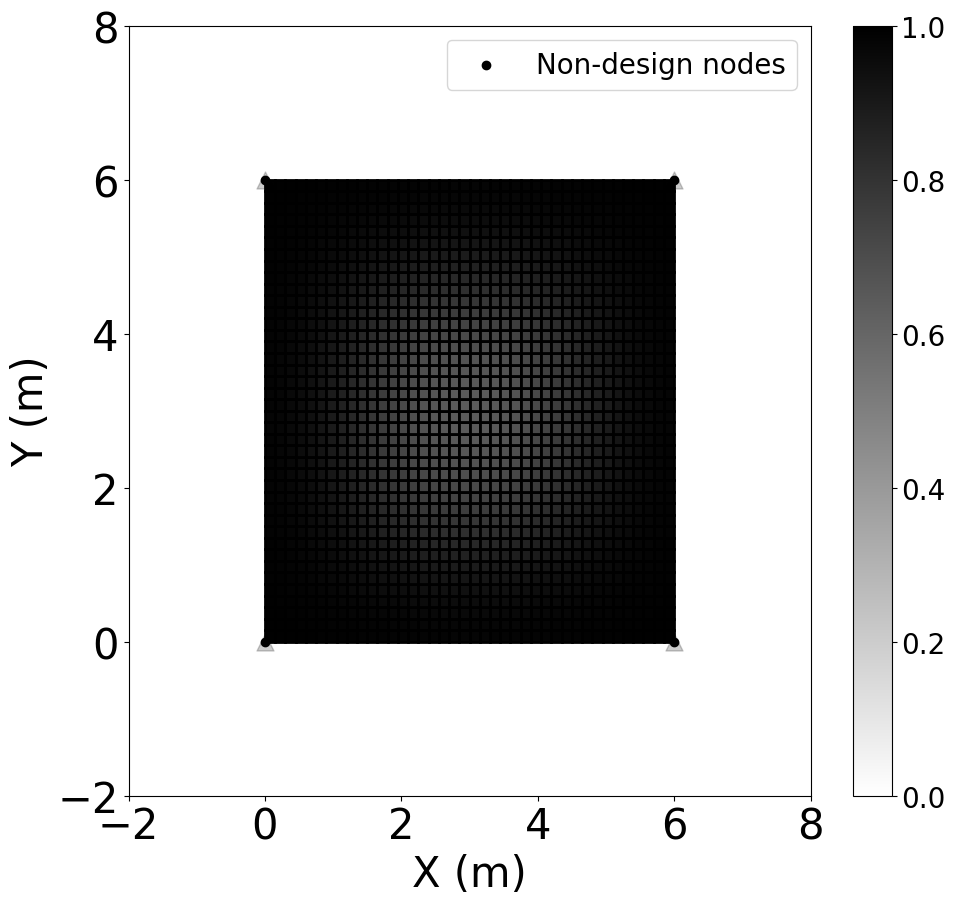

  5%|▌         | 11/205 [00:28<06:05,  1.88s/it]

Train epoch 12  ,loss:0.6687726355009339


  6%|▌         | 12/205 [00:29<05:33,  1.73s/it]

Train epoch 13  ,loss:0.7090885026167923


  6%|▋         | 13/205 [00:31<05:11,  1.62s/it]

Train epoch 14  ,loss:0.751377995323269


  7%|▋         | 14/205 [00:32<04:56,  1.55s/it]

Train epoch 15  ,loss:0.7942342347039636
Train epoch 16  ,loss:0.8367897264929383
1476.119830327034


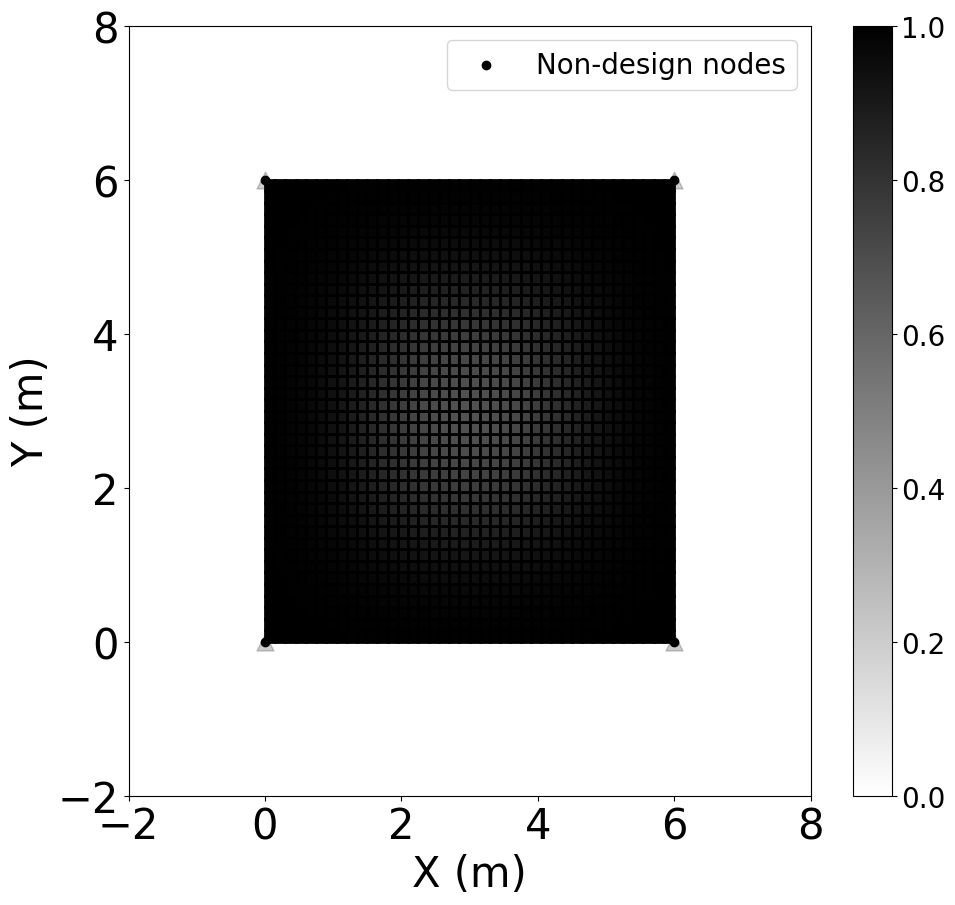

  8%|▊         | 16/205 [00:36<05:30,  1.75s/it]

Train epoch 17  ,loss:0.8784376046249746


  8%|▊         | 17/205 [00:38<05:08,  1.64s/it]

Train epoch 18  ,loss:0.9187014786342349


  9%|▉         | 18/205 [00:39<04:52,  1.56s/it]

Train epoch 19  ,loss:0.9571582742504986


  9%|▉         | 19/205 [00:40<04:40,  1.51s/it]

Train epoch 20  ,loss:0.9933956916202855
Train epoch 21  ,loss:1.0269809671081196
1476.5862465323162


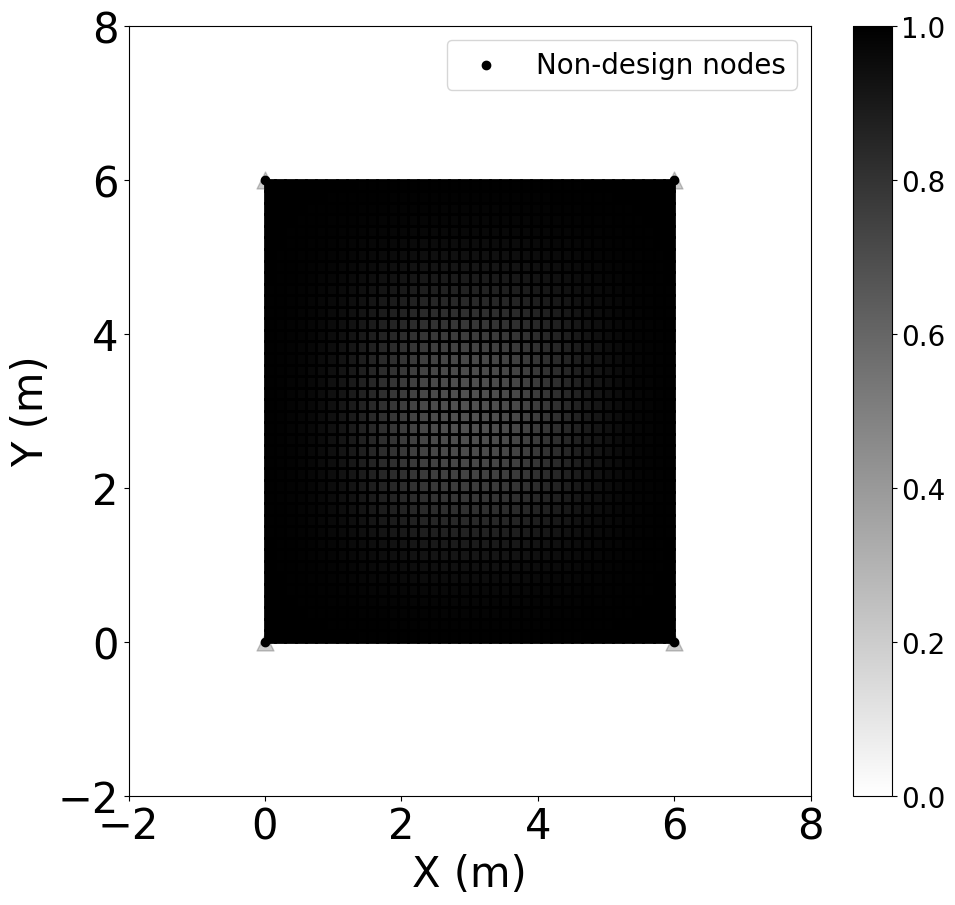

 10%|█         | 21/205 [00:45<05:30,  1.79s/it]

Train epoch 22  ,loss:1.0574371182739528


 11%|█         | 22/205 [00:46<05:05,  1.67s/it]

Train epoch 23  ,loss:1.0842171453955967


 11%|█         | 23/205 [00:48<04:48,  1.58s/it]

Train epoch 24  ,loss:1.1066841423738556


 12%|█▏        | 24/205 [00:49<04:35,  1.52s/it]

Train epoch 25  ,loss:1.1241052485706362
Train epoch 26  ,loss:1.1356553617331109
1433.9660825643414


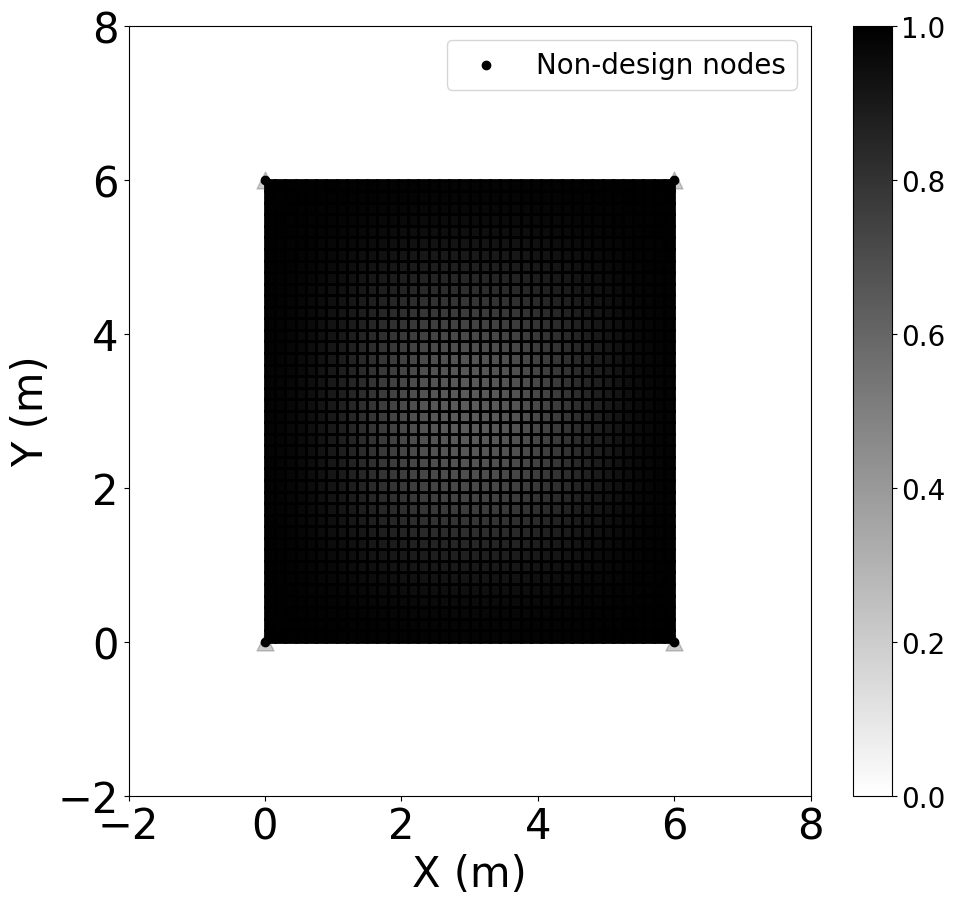

 13%|█▎        | 26/205 [00:53<05:12,  1.75s/it]

Train epoch 27  ,loss:1.1404605073335017


 13%|█▎        | 27/205 [00:55<04:51,  1.64s/it]

Train epoch 28  ,loss:1.1377454094203634


 14%|█▎        | 28/205 [00:56<04:36,  1.56s/it]

Train epoch 29  ,loss:1.1271261327482225


 14%|█▍        | 29/205 [00:57<04:25,  1.51s/it]

Train epoch 30  ,loss:1.1094486027590464
Train epoch 31  ,loss:1.088843417567327
1294.0575773699843


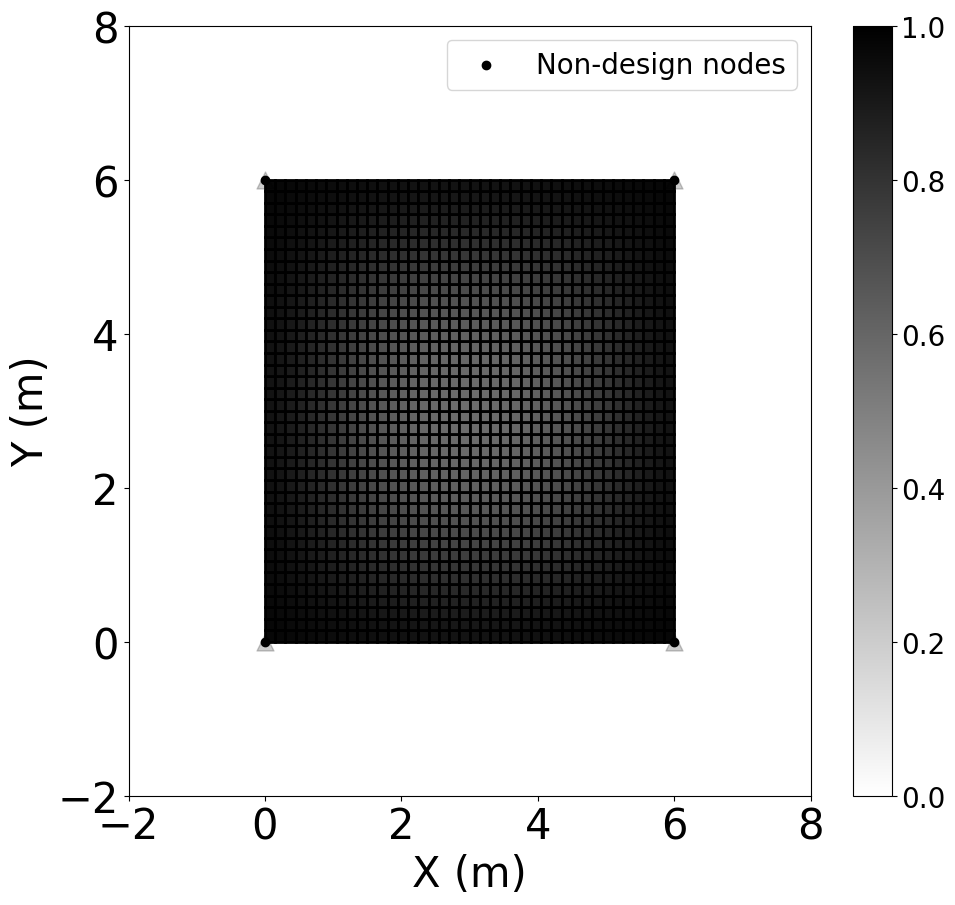

 15%|█▌        | 31/205 [01:02<05:12,  1.80s/it]

Train epoch 32  ,loss:1.077856647678042


 16%|█▌        | 32/205 [01:03<04:49,  1.67s/it]

Train epoch 33  ,loss:1.105894672544086


 16%|█▌        | 33/205 [01:05<04:32,  1.59s/it]

Train epoch 34  ,loss:1.167822938746249


 17%|█▋        | 34/205 [01:06<04:20,  1.52s/it]

Train epoch 35  ,loss:1.1719706105686898
Train epoch 36  ,loss:1.1482822506805408
1251.6695117529912


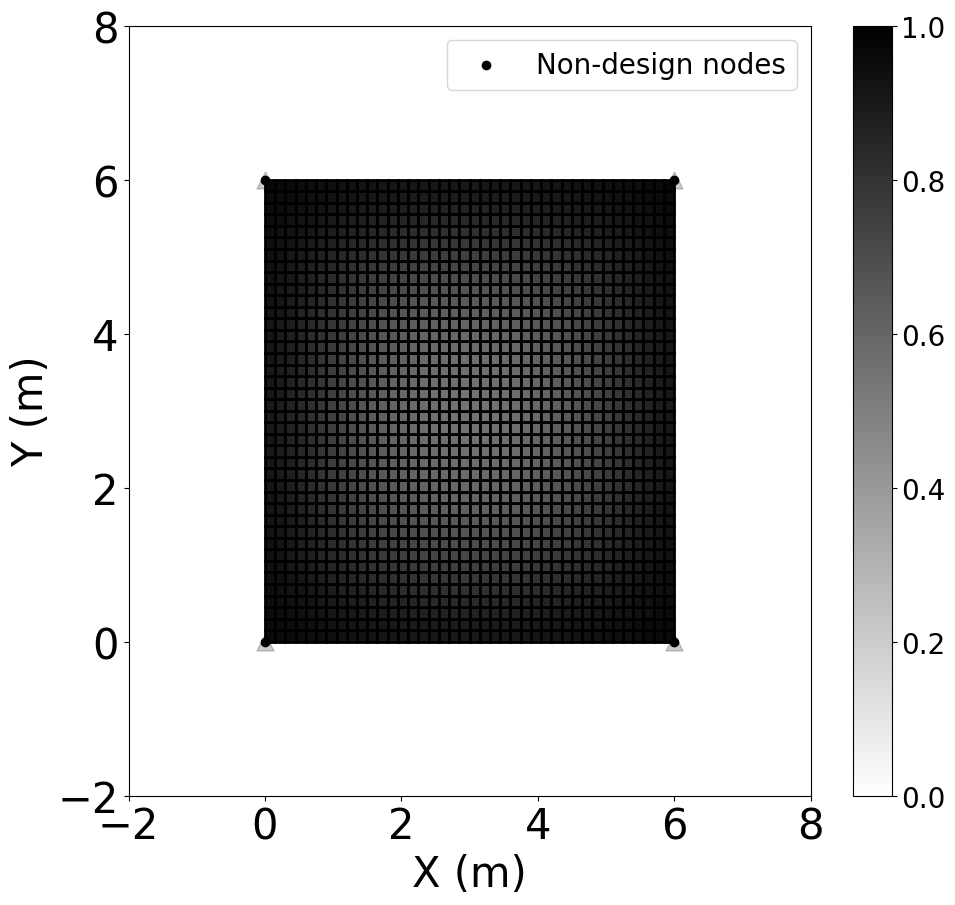

 18%|█▊        | 36/205 [01:10<04:53,  1.74s/it]

Train epoch 37  ,loss:1.1405517092481665


 18%|█▊        | 37/205 [01:12<04:34,  1.63s/it]

Train epoch 38  ,loss:1.1540664753507779


 19%|█▊        | 38/205 [01:13<04:20,  1.56s/it]

Train epoch 39  ,loss:1.1771004276722294


 19%|█▉        | 39/205 [01:14<04:10,  1.51s/it]

Train epoch 40  ,loss:1.1990355263850727
Train epoch 41  ,loss:1.2141224499087242
1288.1301445432769


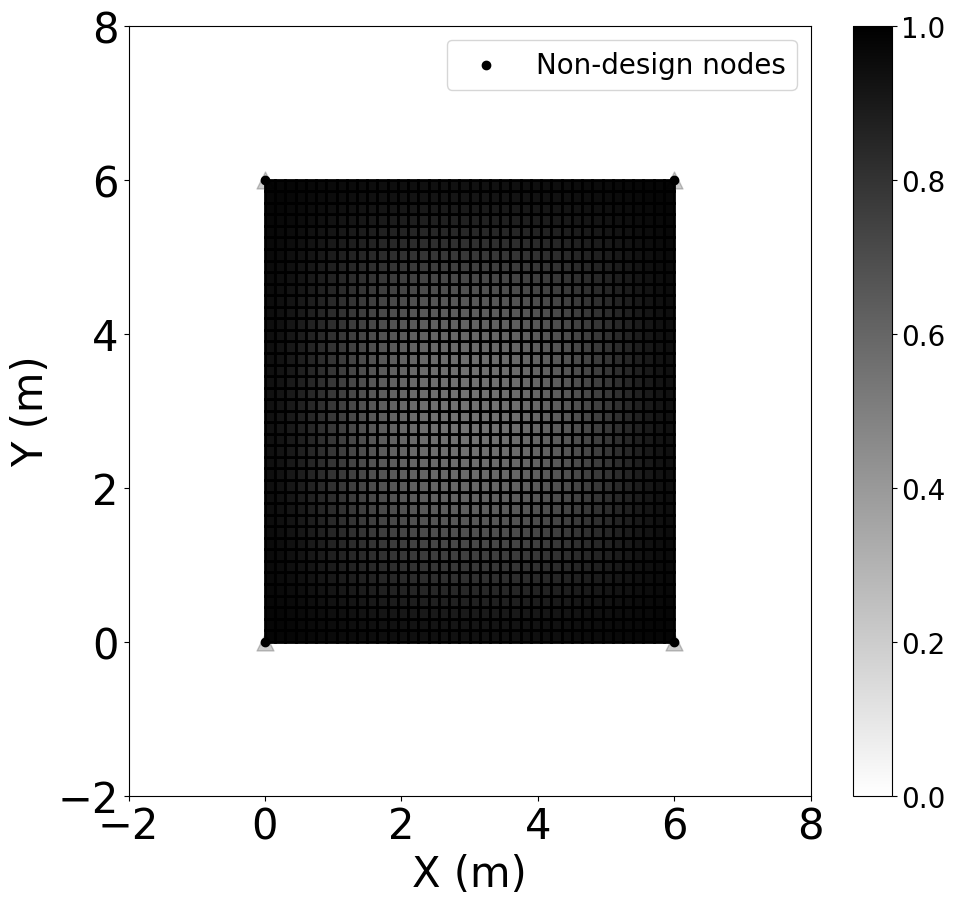

 20%|██        | 41/205 [01:19<04:54,  1.80s/it]

Train epoch 42  ,loss:1.2203152474230523


 20%|██        | 42/205 [01:20<04:32,  1.67s/it]

Train epoch 43  ,loss:1.2183164053832893


 21%|██        | 43/205 [01:22<04:18,  1.60s/it]

Train epoch 44  ,loss:1.2114611032714484


 21%|██▏       | 44/205 [01:23<04:06,  1.53s/it]

Train epoch 45  ,loss:1.2058846234144704
Train epoch 46  ,loss:1.2090723099411302
1189.053215828542


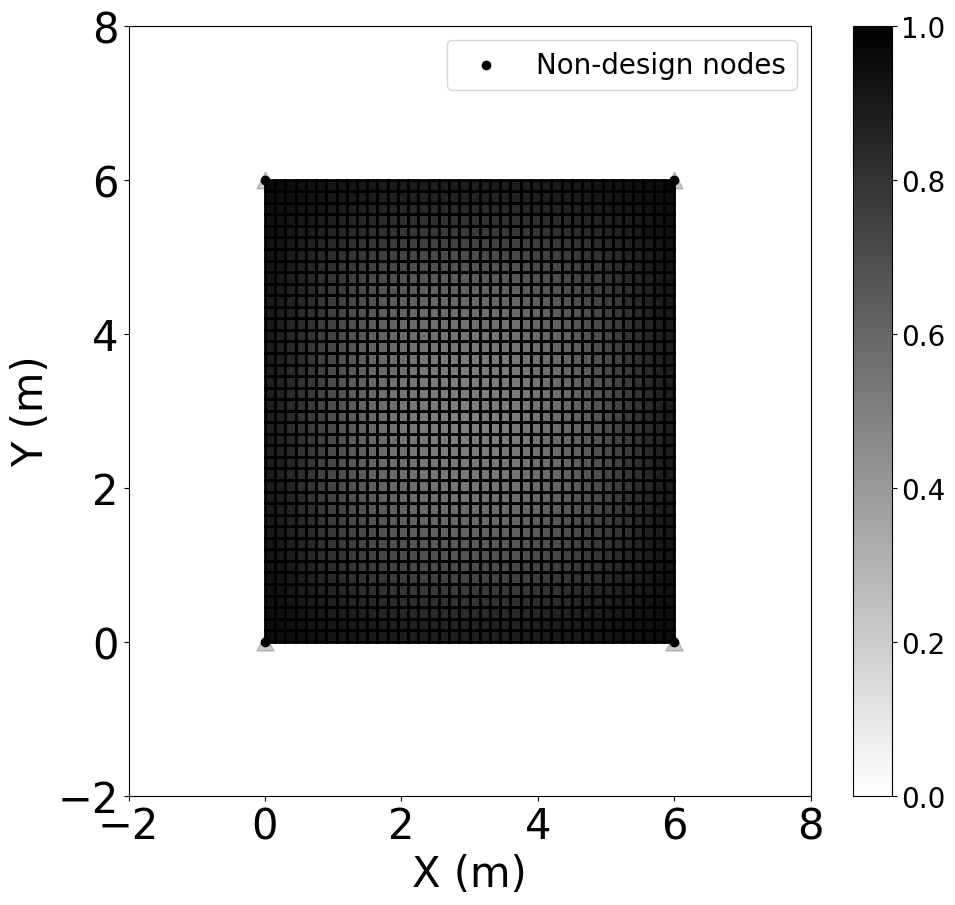

 22%|██▏       | 46/205 [01:27<04:37,  1.74s/it]

Train epoch 47  ,loss:1.222836097537322


 23%|██▎       | 47/205 [01:28<04:18,  1.64s/it]

Train epoch 48  ,loss:1.2346047538580622


 23%|██▎       | 48/205 [01:30<04:04,  1.56s/it]

Train epoch 49  ,loss:1.231253326547061


 24%|██▍       | 49/205 [01:31<03:57,  1.52s/it]

Train epoch 50  ,loss:1.220018338653449
Train epoch 51  ,loss:1.213992137516998
1200.2449323753758


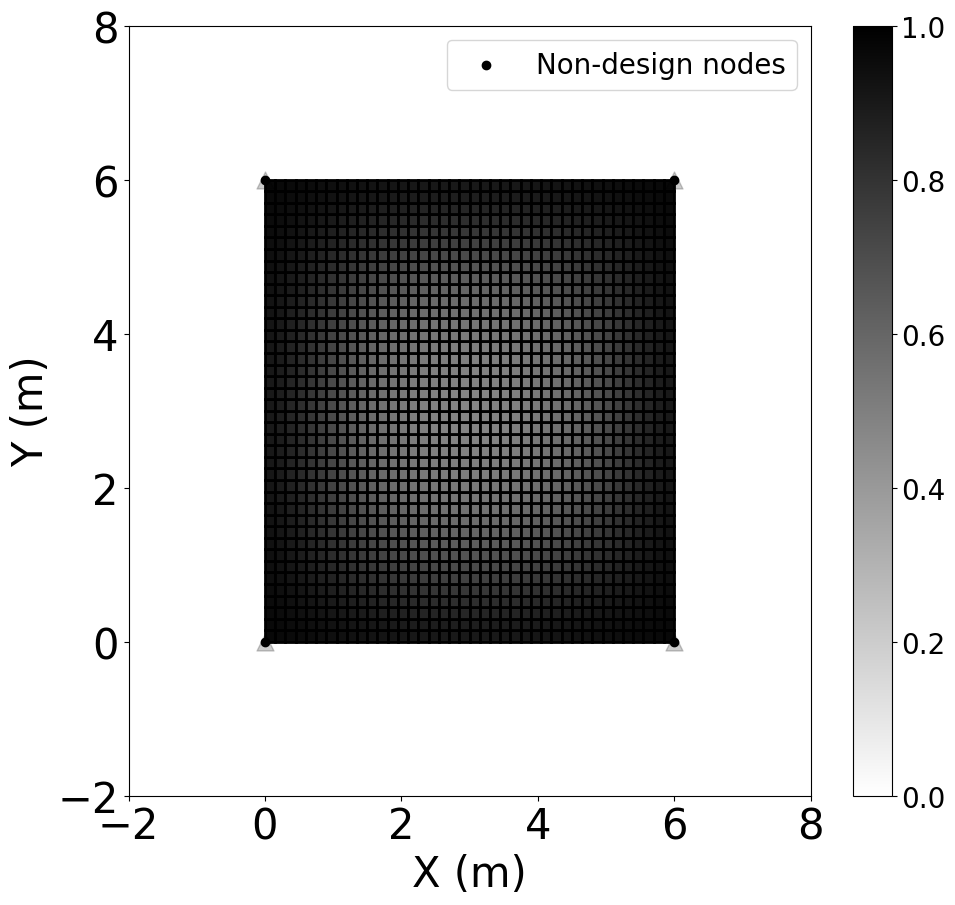

 25%|██▍       | 51/205 [01:36<04:37,  1.80s/it]

Train epoch 52  ,loss:1.213877578340799


 25%|██▌       | 52/205 [01:37<04:16,  1.68s/it]

Train epoch 53  ,loss:1.2133451089307683


 26%|██▌       | 53/205 [01:38<04:01,  1.59s/it]

Train epoch 54  ,loss:1.20732373280389


 26%|██▋       | 54/205 [01:40<03:50,  1.53s/it]

Train epoch 55  ,loss:1.1950145350325918
Train epoch 56  ,loss:1.1799822835662004
1144.5837524428905


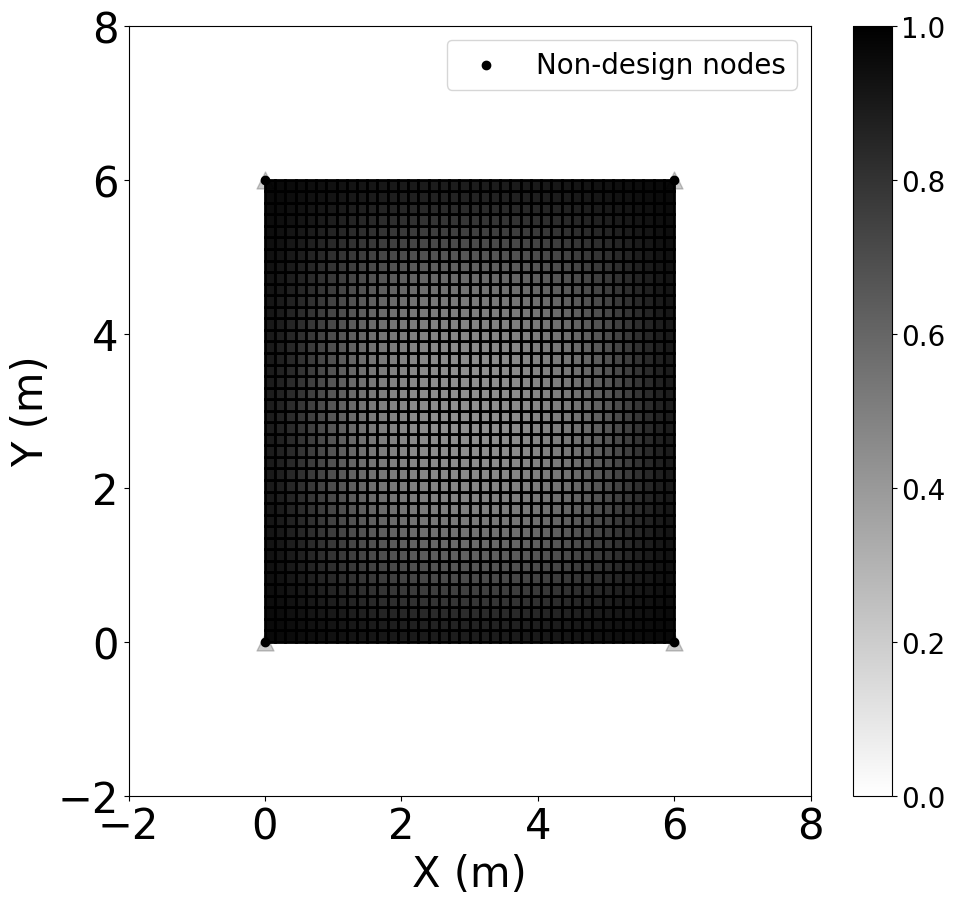

 27%|██▋       | 56/205 [01:44<04:19,  1.74s/it]

Train epoch 57  ,loss:1.1667663226170366


 28%|██▊       | 57/205 [01:45<04:02,  1.64s/it]

Train epoch 58  ,loss:1.1523045247311792


 28%|██▊       | 58/205 [01:47<03:49,  1.56s/it]

Train epoch 59  ,loss:1.1310272442379974


 29%|██▉       | 59/205 [01:48<03:39,  1.51s/it]

Train epoch 60  ,loss:1.1021550111408709
Train epoch 61  ,loss:1.071689487584164
1114.3441846560595


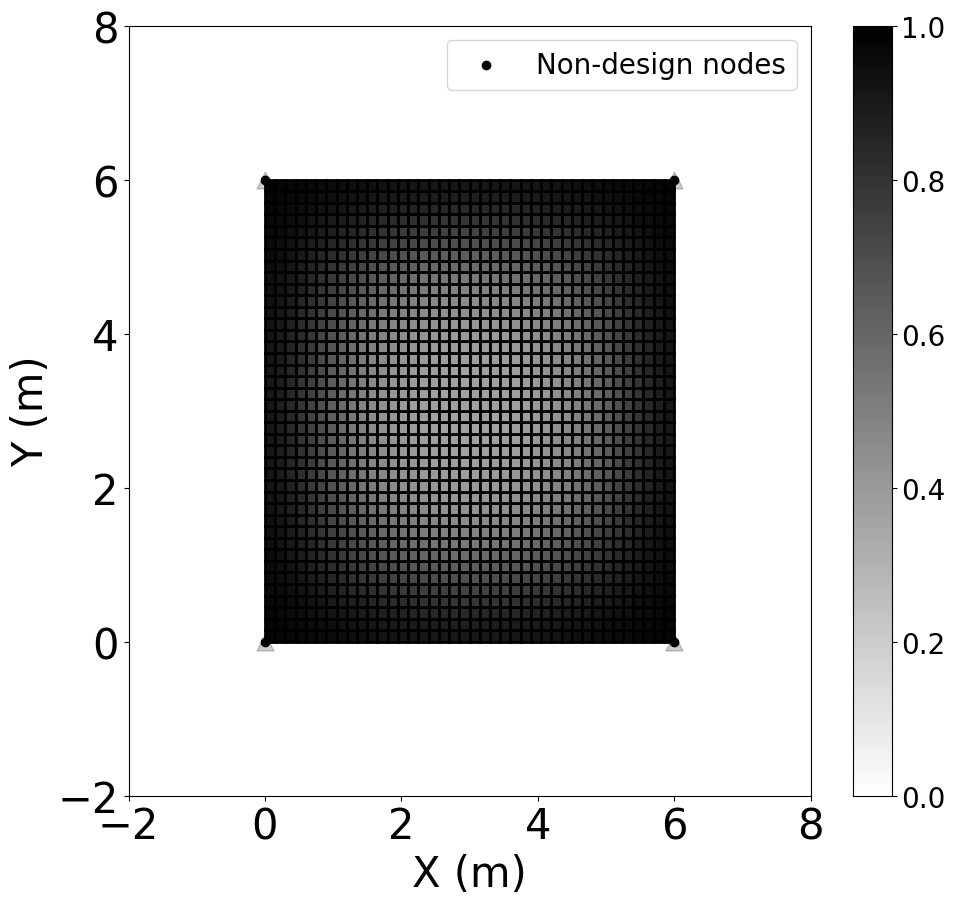

 30%|██▉       | 61/205 [01:52<04:10,  1.74s/it]

Train epoch 62  ,loss:1.0384231399509614


 30%|███       | 62/205 [01:54<03:53,  1.64s/it]

Train epoch 63  ,loss:0.9950620092574141


 31%|███       | 63/205 [01:55<03:41,  1.56s/it]

Train epoch 64  ,loss:0.9529635396828103


 31%|███       | 64/205 [01:56<03:32,  1.51s/it]

Train epoch 65  ,loss:0.9119512680351877
Train epoch 66  ,loss:0.862469310310294
1021.6084793246971


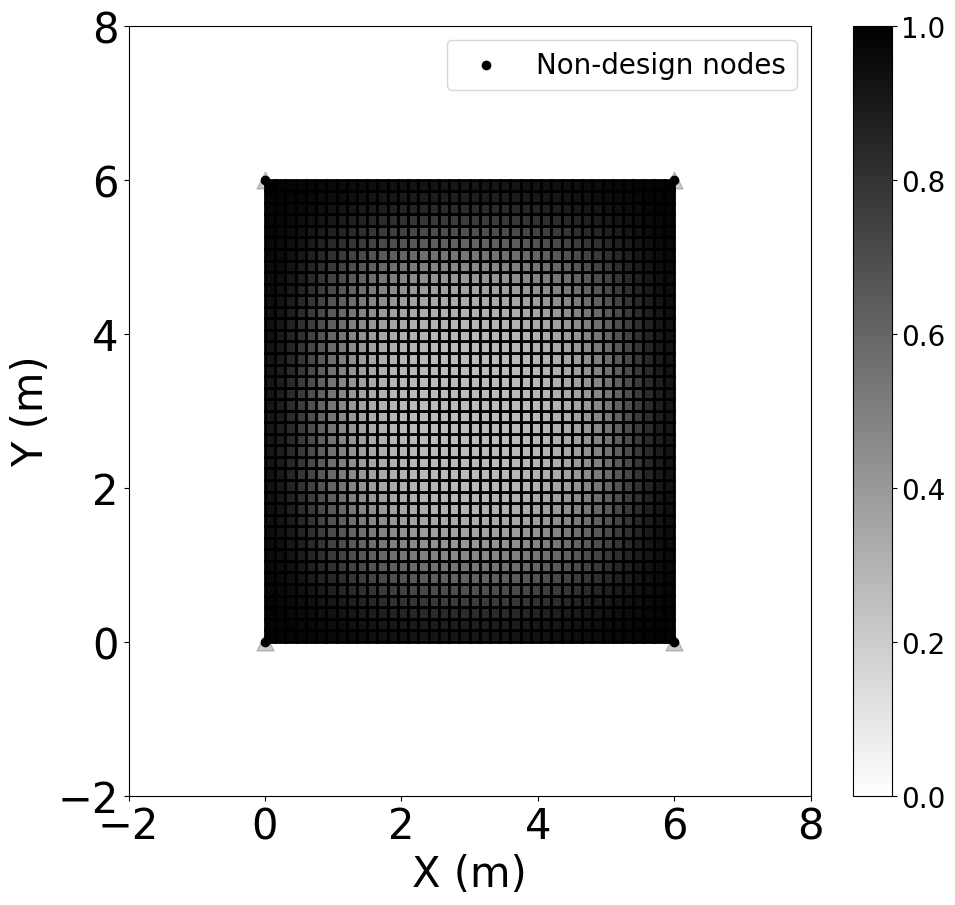

 32%|███▏      | 66/205 [02:01<04:11,  1.81s/it]

Train epoch 67  ,loss:0.817940689870056


 33%|███▎      | 67/205 [02:02<03:51,  1.68s/it]

Train epoch 68  ,loss:0.7770846678120839


 33%|███▎      | 68/205 [02:04<03:38,  1.59s/it]

Train epoch 69  ,loss:0.7346828987458098


 34%|███▎      | 69/205 [02:05<03:29,  1.54s/it]

Train epoch 70  ,loss:0.6930993902647878
Train epoch 71  ,loss:0.649776777543668
946.7130375877716


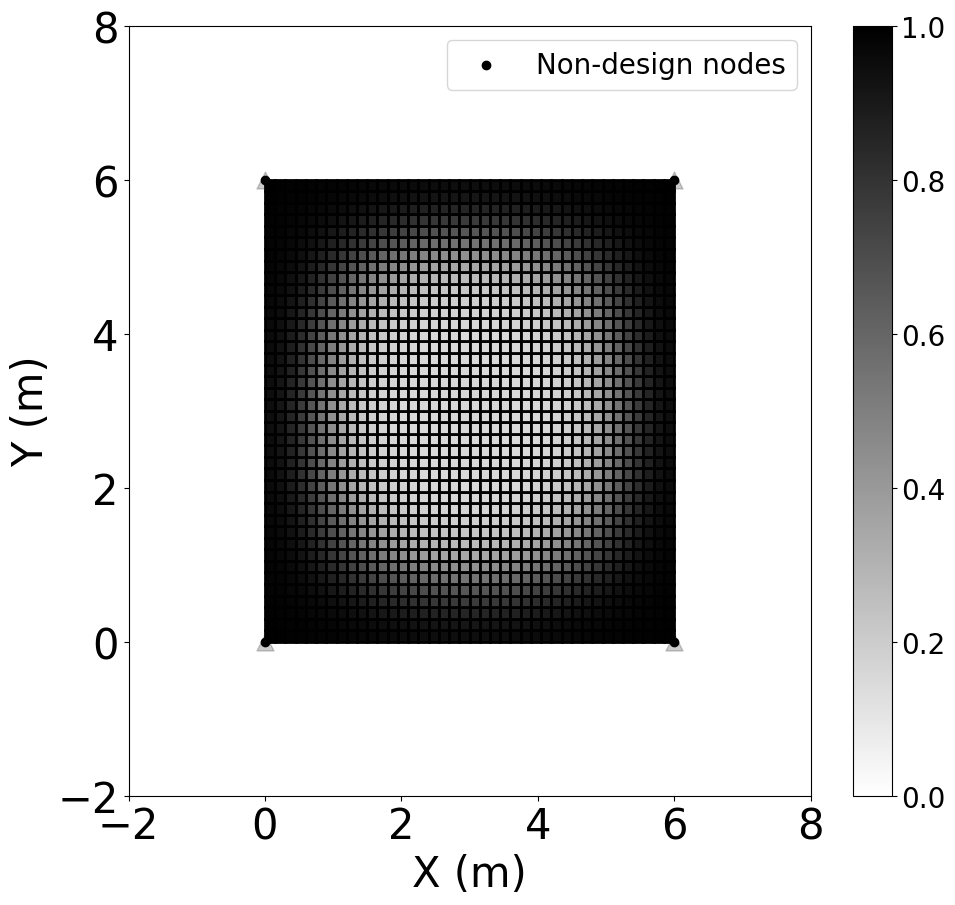

 35%|███▍      | 71/205 [02:09<03:53,  1.74s/it]

Train epoch 72  ,loss:0.6098927849178845


 35%|███▌      | 72/205 [02:11<03:37,  1.64s/it]

Train epoch 73  ,loss:0.573043230001182


 36%|███▌      | 73/205 [02:12<03:25,  1.56s/it]

Train epoch 74  ,loss:0.5376020025643107


 36%|███▌      | 74/205 [02:13<03:17,  1.51s/it]

Train epoch 75  ,loss:0.5053100460616572
Train epoch 76  ,loss:0.478987390137012
875.3637453353504


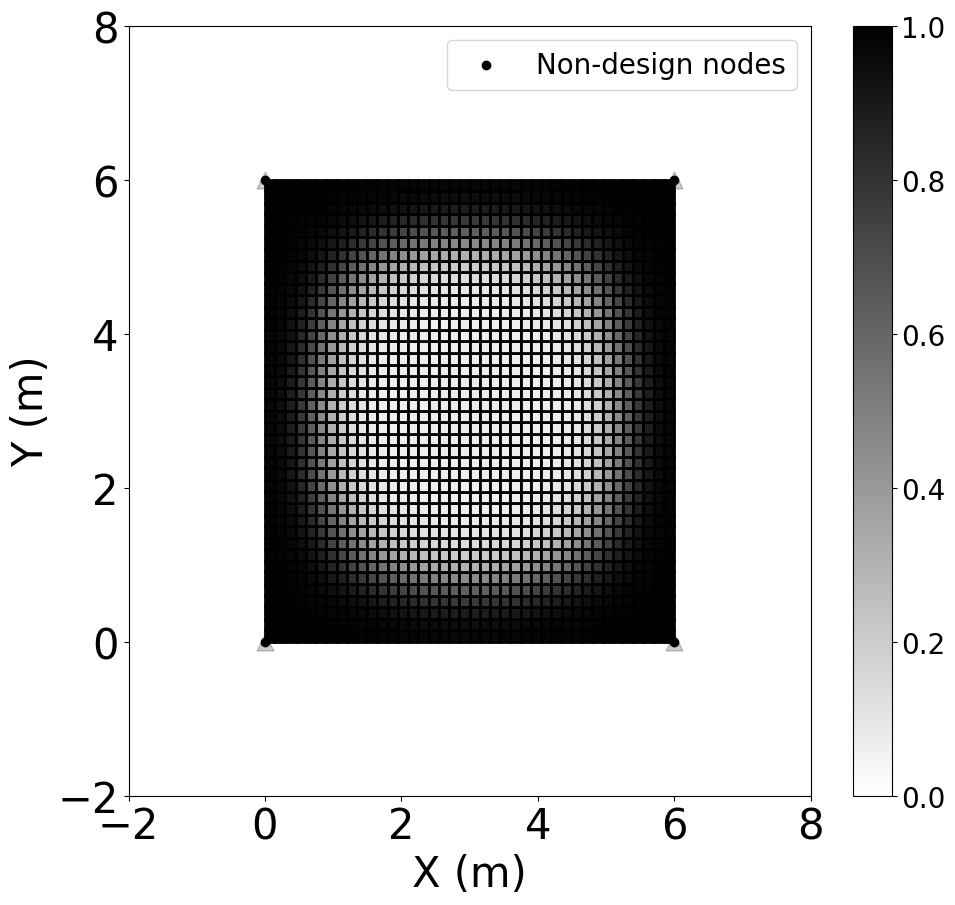

 37%|███▋      | 76/205 [02:18<03:51,  1.79s/it]

Train epoch 77  ,loss:0.45559704642669097


 38%|███▊      | 77/205 [02:19<03:35,  1.68s/it]

Train epoch 78  ,loss:0.4349987883874982


 38%|███▊      | 78/205 [02:21<03:21,  1.59s/it]

Train epoch 79  ,loss:0.41832888311868616


 39%|███▊      | 79/205 [02:22<03:13,  1.53s/it]

Train epoch 80  ,loss:0.40363352304620487
Train epoch 81  ,loss:0.39102609938354993
847.2854000017871


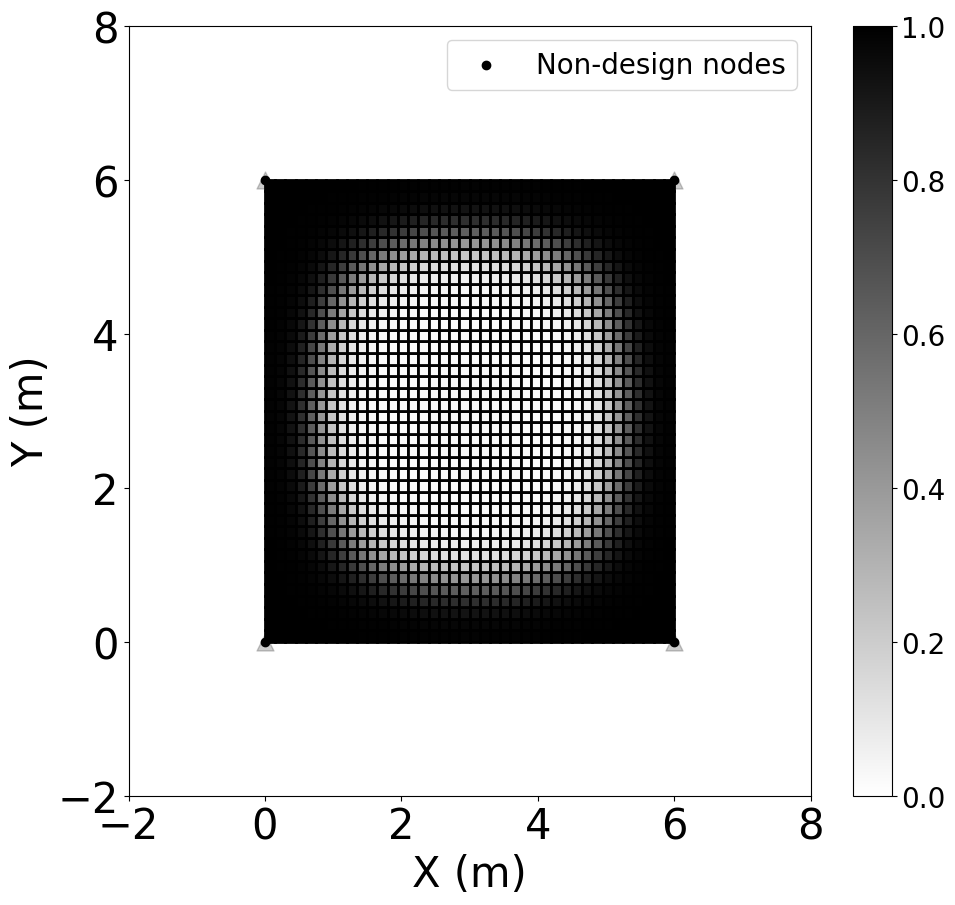

 40%|███▉      | 81/205 [02:26<03:36,  1.74s/it]

Train epoch 82  ,loss:0.3807546457757592


 40%|████      | 82/205 [02:28<03:20,  1.63s/it]

Train epoch 83  ,loss:0.3718934848046851


 40%|████      | 83/205 [02:29<03:09,  1.56s/it]

Train epoch 84  ,loss:0.36391137545678276


 41%|████      | 84/205 [02:30<03:01,  1.50s/it]

Train epoch 85  ,loss:0.35831580545168606
Train epoch 86  ,loss:0.353115277036527
842.0918667181595


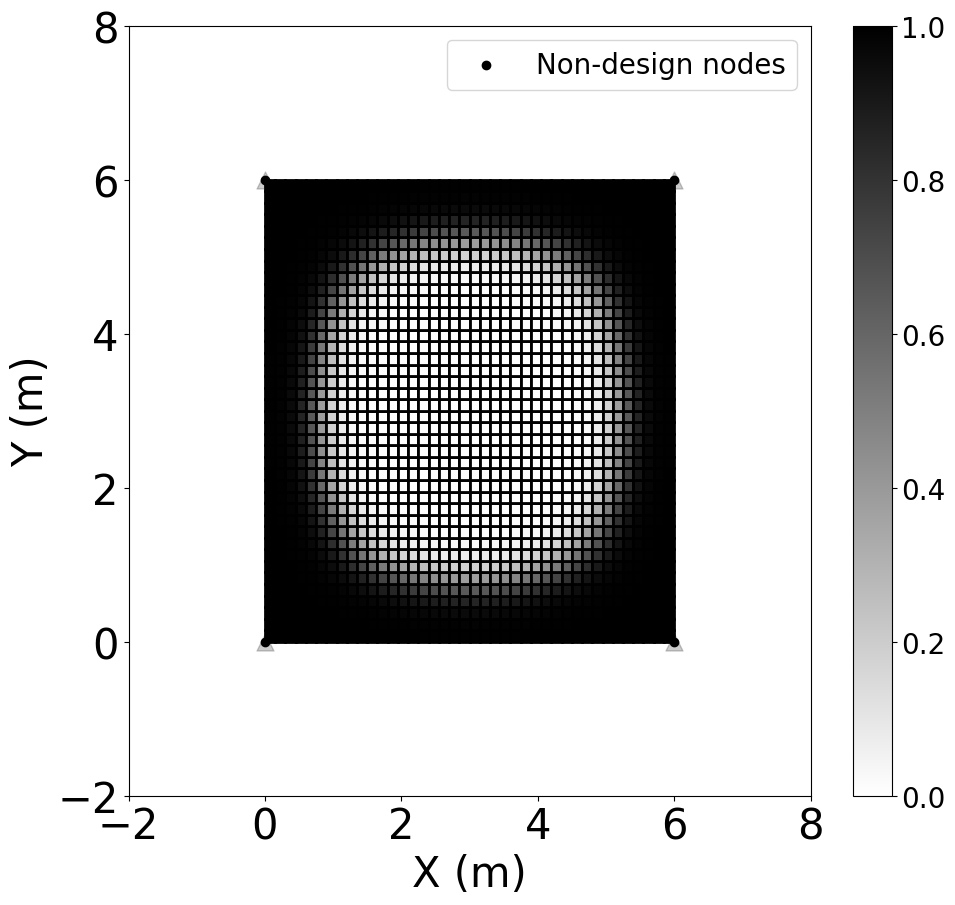

 42%|████▏     | 86/205 [02:35<03:33,  1.80s/it]

Train epoch 87  ,loss:0.3484898778173749


 42%|████▏     | 87/205 [02:36<03:17,  1.67s/it]

Train epoch 88  ,loss:0.3445349659920872


 43%|████▎     | 88/205 [02:37<03:05,  1.58s/it]

Train epoch 89  ,loss:0.3410895620716482


 43%|████▎     | 89/205 [02:39<02:56,  1.52s/it]

Train epoch 90  ,loss:0.3383961082682037
Train epoch 91  ,loss:0.3359841399854857
827.7036983433346


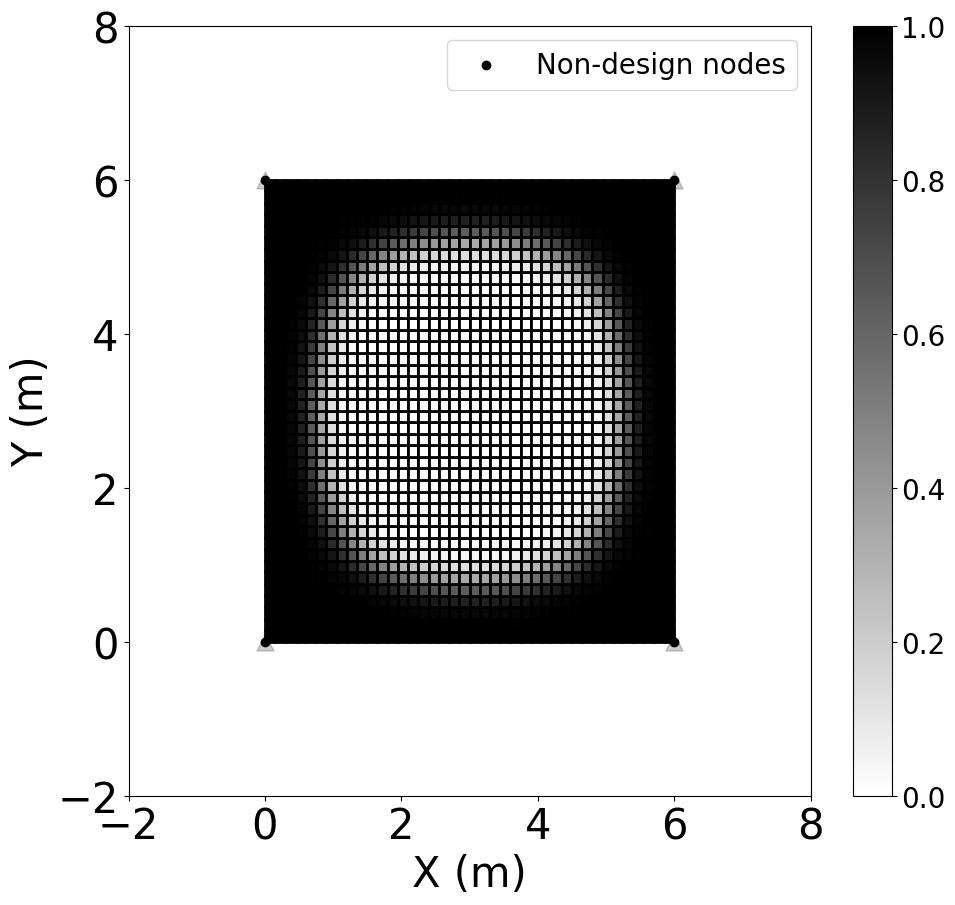

 44%|████▍     | 91/205 [02:43<03:18,  1.74s/it]

Train epoch 92  ,loss:0.3334768226219467


 45%|████▍     | 92/205 [02:44<03:04,  1.63s/it]

Train epoch 93  ,loss:0.3315217853699708


 45%|████▌     | 93/205 [02:46<02:54,  1.55s/it]

Train epoch 94  ,loss:0.3299481005960782


 46%|████▌     | 94/205 [02:47<02:46,  1.50s/it]

Train epoch 95  ,loss:0.32834191469081786
Train epoch 96  ,loss:0.3268661456944093
824.7779521058742


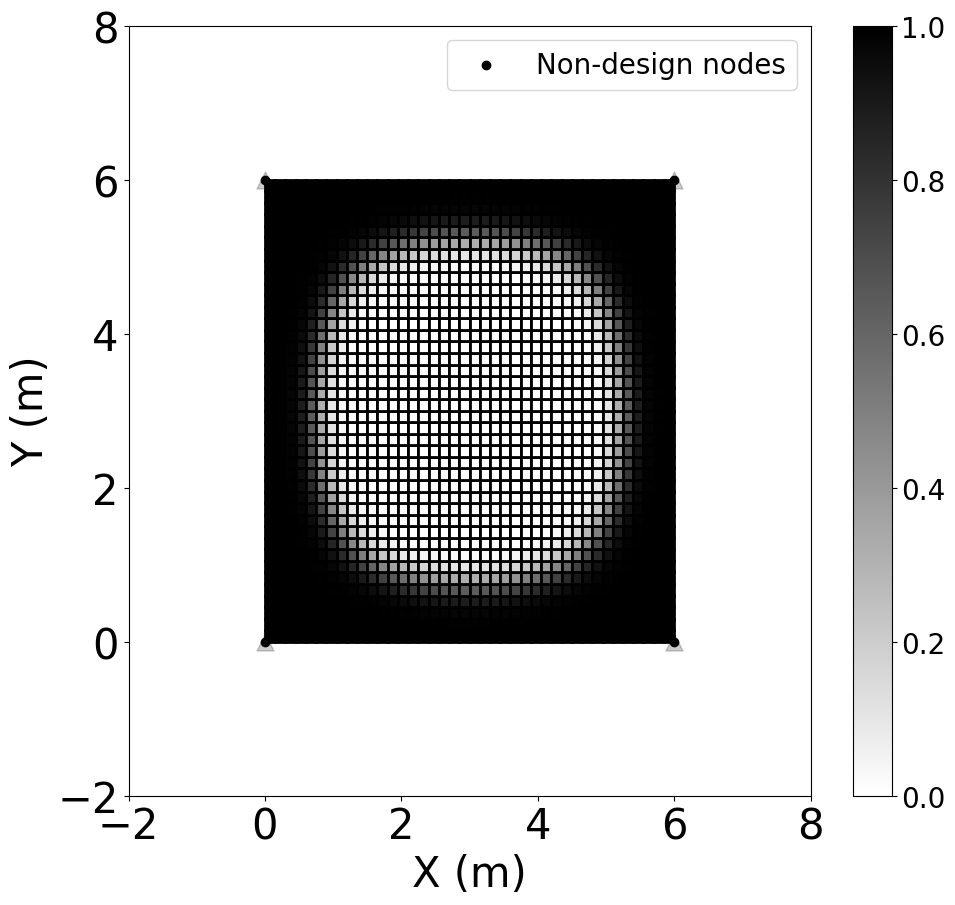

 47%|████▋     | 96/205 [02:52<03:15,  1.80s/it]

Train epoch 97  ,loss:0.3256854906586588


 47%|████▋     | 97/205 [02:53<03:00,  1.67s/it]

Train epoch 98  ,loss:0.3246034121919117


 48%|████▊     | 98/205 [02:54<02:49,  1.59s/it]

Train epoch 99  ,loss:0.3235320503674325


 48%|████▊     | 99/205 [02:56<02:43,  1.54s/it]

Train epoch 100  ,loss:0.32258346300021085
Train epoch 101  ,loss:0.3217559471462183
823.179386531994


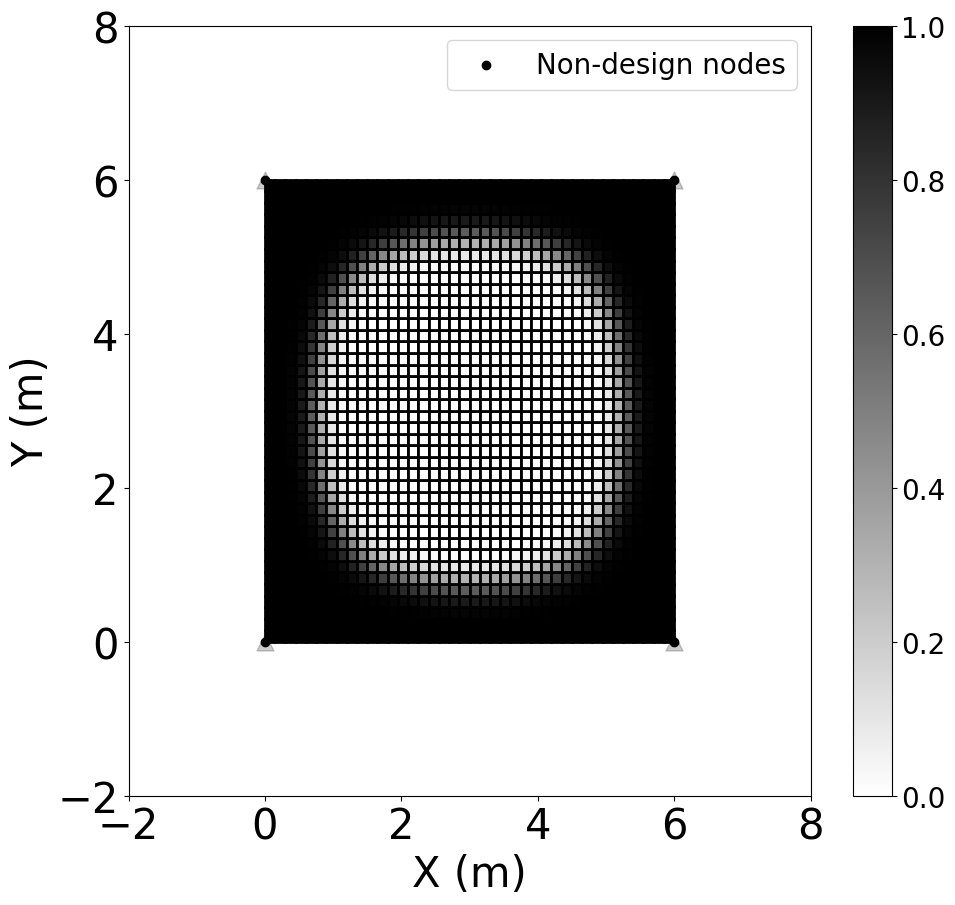

 49%|████▉     | 101/205 [03:00<03:03,  1.77s/it]

Train epoch 102  ,loss:0.32101768557359645


 50%|████▉     | 102/205 [03:01<02:50,  1.65s/it]

Train epoch 103  ,loss:0.3203608062453478


 50%|█████     | 103/205 [03:03<02:40,  1.57s/it]

Train epoch 104  ,loss:0.31970809083544754


 51%|█████     | 104/205 [03:04<02:32,  1.51s/it]

Train epoch 105  ,loss:0.31913396827058416
Train epoch 106  ,loss:0.31859963548219655
821.2254265704762


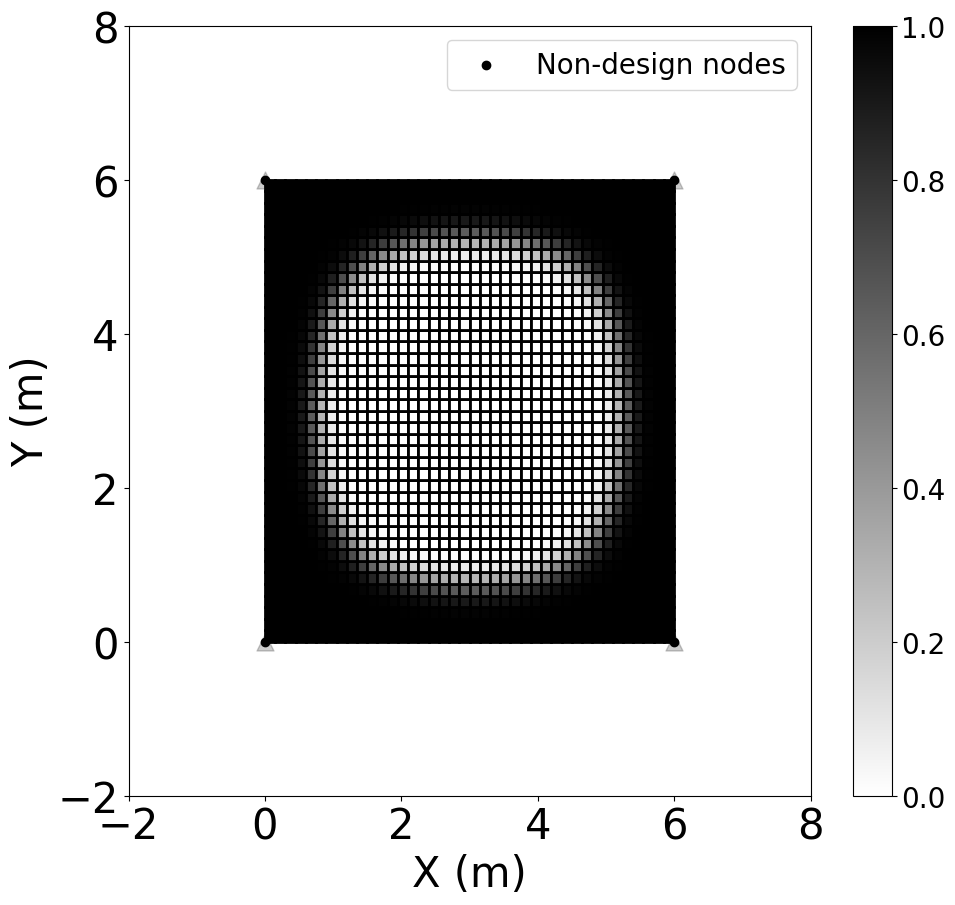

 52%|█████▏    | 106/205 [03:08<02:51,  1.73s/it]

Train epoch 107  ,loss:0.3181068179350509


 52%|█████▏    | 107/205 [03:10<02:38,  1.62s/it]

Train epoch 108  ,loss:0.3176636707124194


 53%|█████▎    | 108/205 [03:11<02:30,  1.55s/it]

Train epoch 109  ,loss:0.3172342627629515


 53%|█████▎    | 109/205 [03:12<02:23,  1.50s/it]

Train epoch 110  ,loss:0.31685118196140877
Train epoch 111  ,loss:0.3164906722270094
819.8246897795044


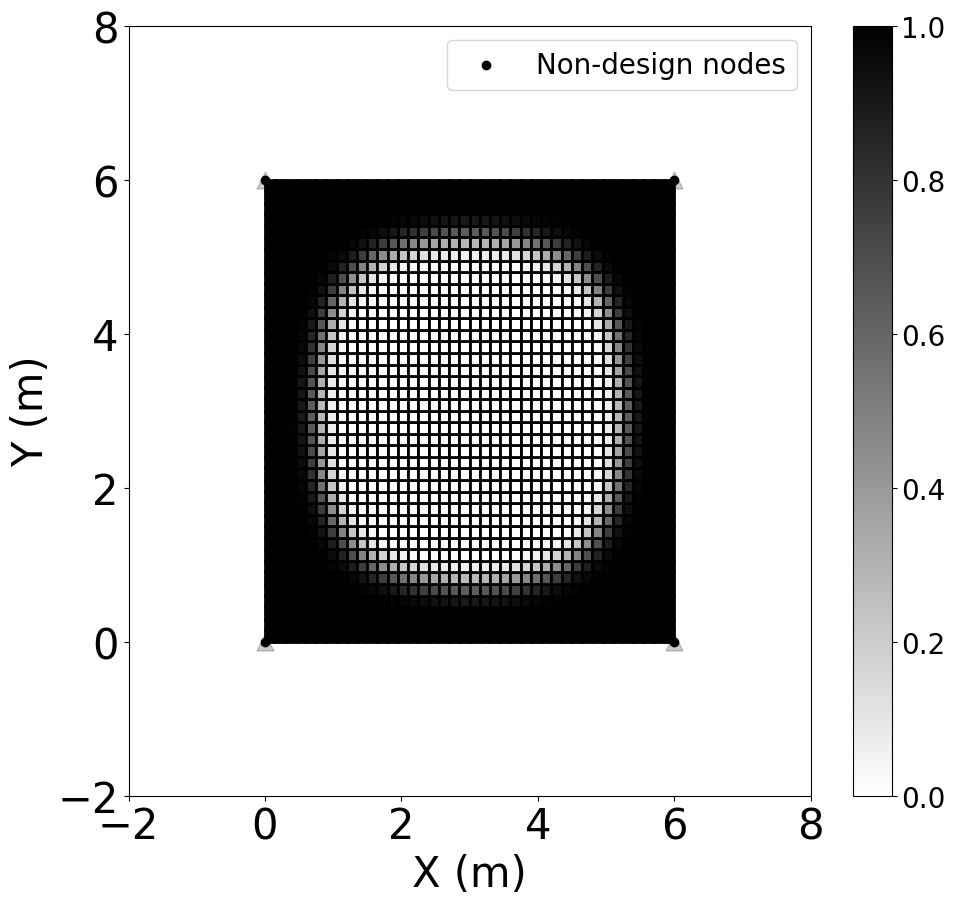

 54%|█████▍    | 111/205 [03:17<02:48,  1.80s/it]

Train epoch 112  ,loss:0.31615004089458404


 55%|█████▍    | 112/205 [03:18<02:35,  1.67s/it]

Train epoch 113  ,loss:0.3158407088333637


 55%|█████▌    | 113/205 [03:20<02:25,  1.58s/it]

Train epoch 114  ,loss:0.31554091032742804


 56%|█████▌    | 114/205 [03:21<02:18,  1.52s/it]

Train epoch 115  ,loss:0.3152658583557807
Train epoch 116  ,loss:0.31500552244736024
818.6037005006264


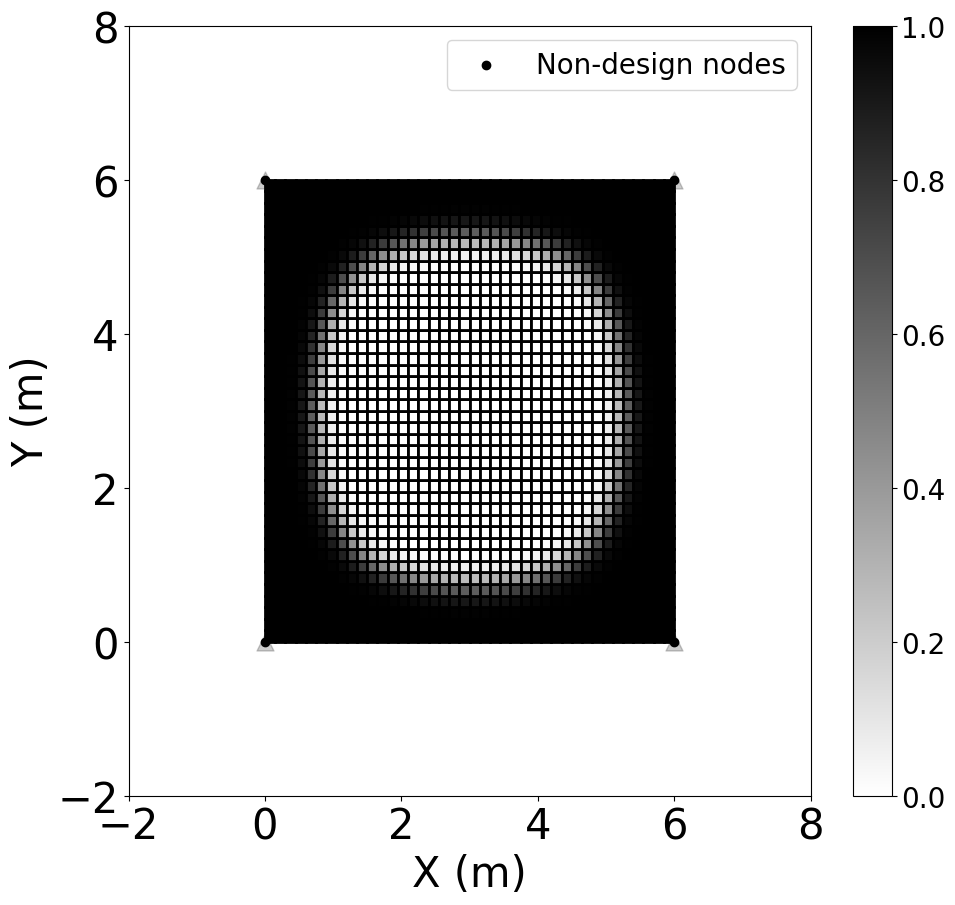

 57%|█████▋    | 116/205 [03:25<02:34,  1.73s/it]

Train epoch 117  ,loss:0.314758406085116


 57%|█████▋    | 117/205 [03:26<02:23,  1.63s/it]

Train epoch 118  ,loss:0.31450814625523926


 58%|█████▊    | 118/205 [03:28<02:15,  1.56s/it]

Train epoch 119  ,loss:0.31420048154622726


 58%|█████▊    | 119/205 [03:29<02:09,  1.50s/it]

Train epoch 120  ,loss:0.3139109229456996
Train epoch 121  ,loss:0.31361916866434963
817.377156167194


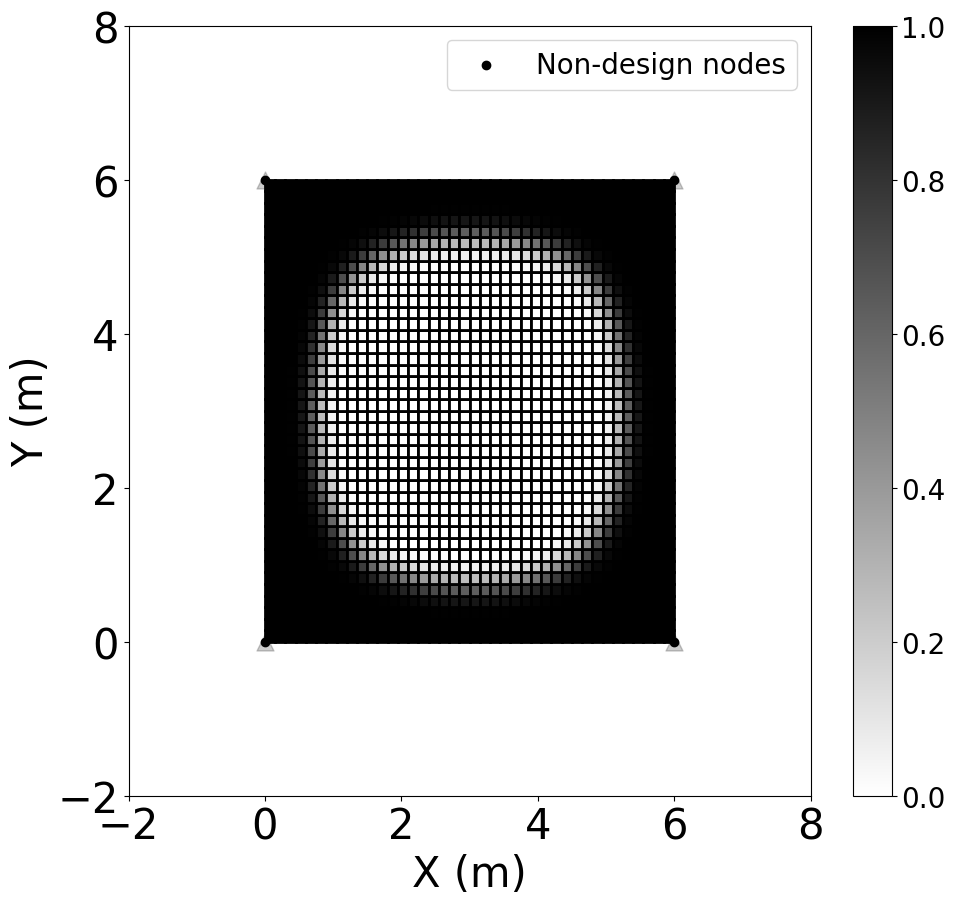

 59%|█████▉    | 121/205 [03:34<02:30,  1.79s/it]

Train epoch 122  ,loss:0.31332381342865867


 60%|█████▉    | 122/205 [03:35<02:18,  1.66s/it]

Train epoch 123  ,loss:0.3130345775284995


 60%|██████    | 123/205 [03:36<02:09,  1.58s/it]

Train epoch 124  ,loss:0.31274644775130955


 60%|██████    | 124/205 [03:38<02:02,  1.51s/it]

Train epoch 125  ,loss:0.31247453789877744
Train epoch 126  ,loss:0.31219657561075026
816.2294383762891


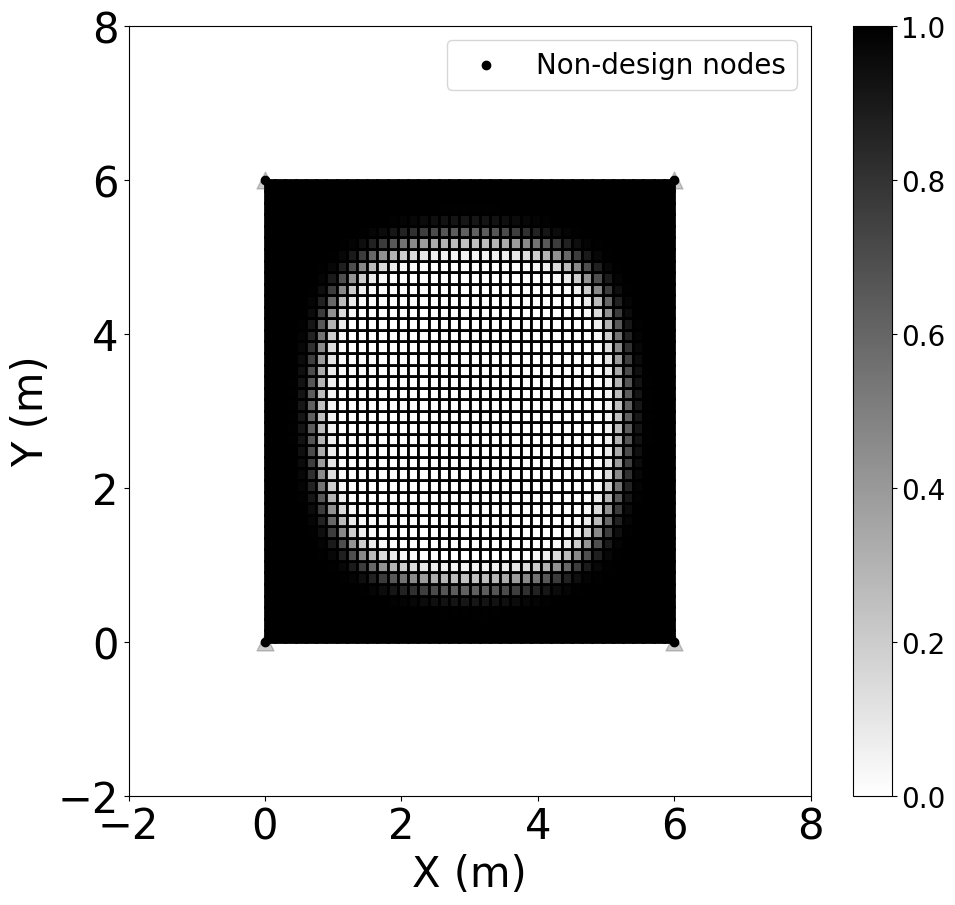

 61%|██████▏   | 126/205 [03:42<02:16,  1.73s/it]

Train epoch 127  ,loss:0.31194503022428777


 62%|██████▏   | 127/205 [03:43<02:06,  1.62s/it]

Train epoch 128  ,loss:0.31170499879393454


 62%|██████▏   | 128/205 [03:45<01:58,  1.54s/it]

Train epoch 129  ,loss:0.31149231018172424


 63%|██████▎   | 129/205 [03:46<01:53,  1.49s/it]

Train epoch 130  ,loss:0.3112898220733749
Train epoch 131  ,loss:0.3111129248484691
816.1079197437024


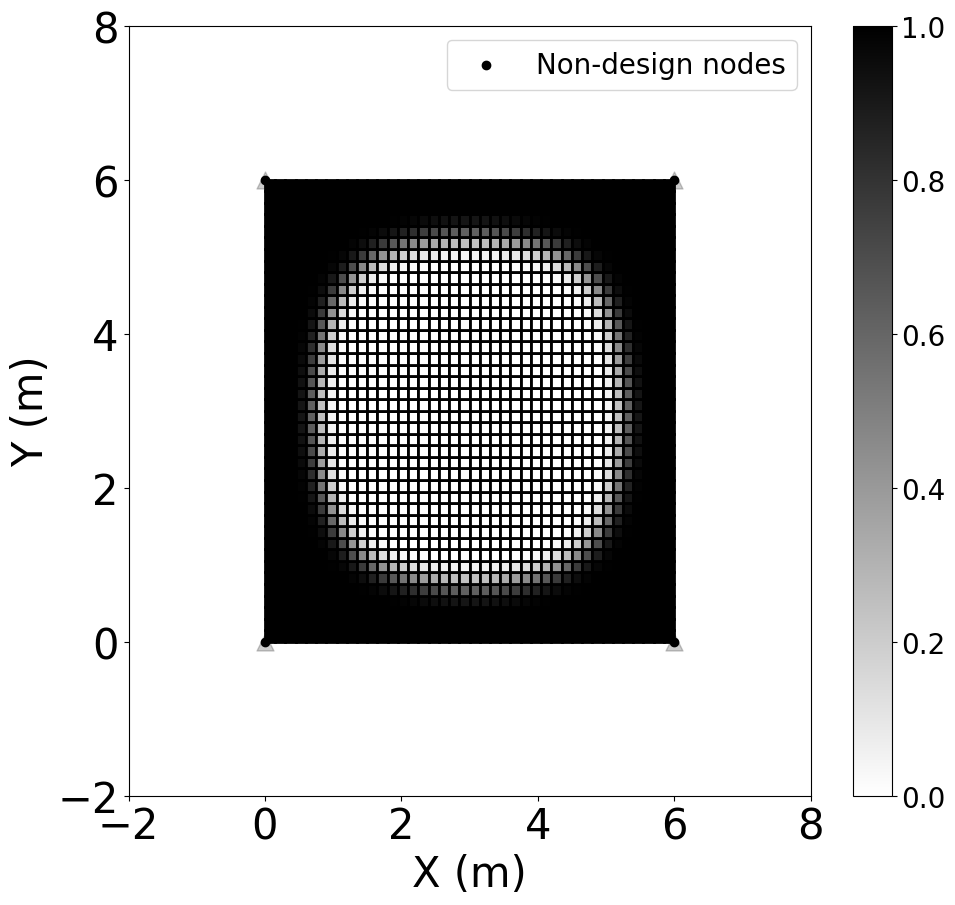

 64%|██████▍   | 131/205 [03:50<02:11,  1.78s/it]

Train epoch 132  ,loss:0.31094914427565534


 64%|██████▍   | 132/205 [03:52<02:01,  1.66s/it]

Train epoch 133  ,loss:0.31080211242019135


 65%|██████▍   | 133/205 [03:53<01:53,  1.58s/it]

Train epoch 134  ,loss:0.3106656049037317


 65%|██████▌   | 134/205 [03:55<01:47,  1.51s/it]

Train epoch 135  ,loss:0.3105411792221422
Train epoch 136  ,loss:0.3104290086566542
814.8236589517712


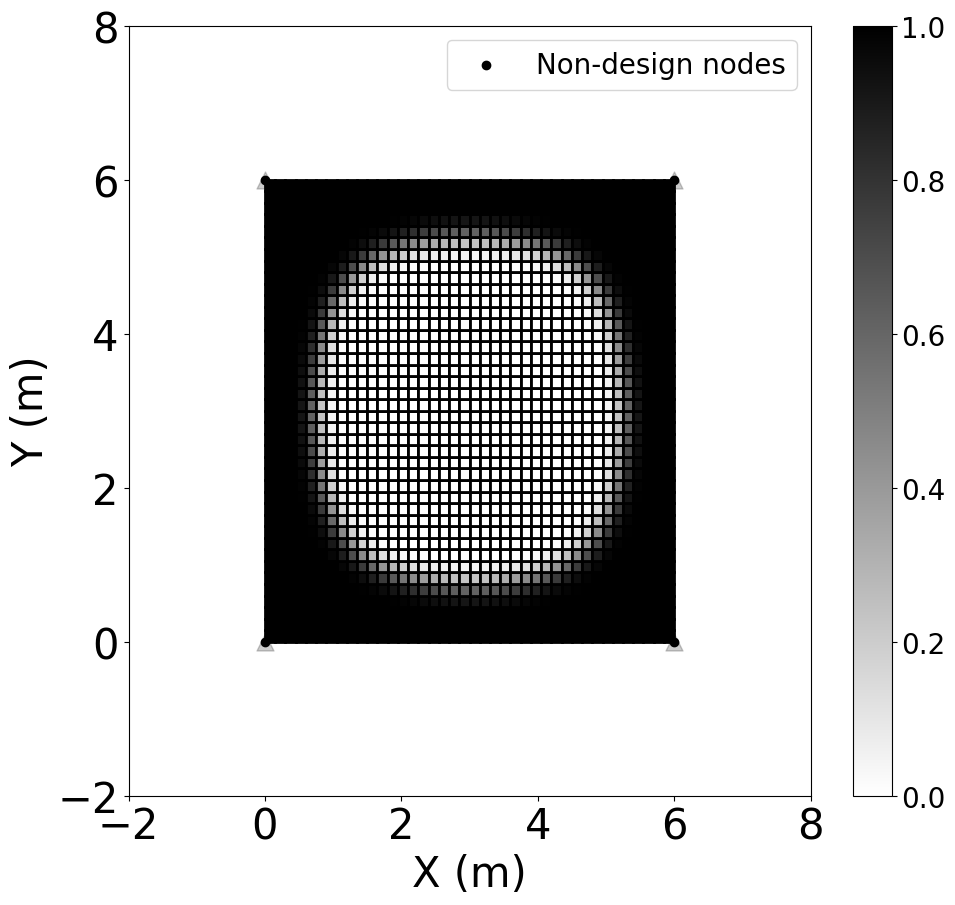

 66%|██████▋   | 136/205 [03:59<01:59,  1.73s/it]

Train epoch 137  ,loss:0.310323232926975


 67%|██████▋   | 137/205 [04:00<01:50,  1.62s/it]

Train epoch 138  ,loss:0.31022912396205193


 67%|██████▋   | 138/205 [04:01<01:44,  1.56s/it]

Train epoch 139  ,loss:0.3101428623375118


In [ ]:
trained_model_state = train_model(model_state, num_epochs=205)

In [ ]:
##Apply_fn: ML input to output
outs = trained_model_state.apply_fn(trained_model_state.params, inp) #how to move nodes along z, ML-Outpu
node_rho_params = outs.reshape(-1)


#Final density
mu_opt = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell

In [125]:
non_design_nodes

array([  20,  820,  860, 1660])

In [130]:
design_nodes[20]

20

In [123]:
zs[non_design_nodes]

array([0.53679601, 2.9963183 , 1.62004906, 1.69808352])

# Visualization

In [ ]:
%matplotlib inline




fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')


import matplotlib as mpl
cmap = mpl.colormaps['binary']
mu_opt_filtered = B_ij_shell@mu_opt
for i in range(n_ele):
    all_corners = []
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])
    #all_corners.append([[xs[inode],ys[inode],zs[inode]],
    #                    [xs[jnode],ys[jnode],zs[jnode]],
    #                    [xs[mnode],ys[mnode],zs[mnode]],
    #                    [xs[nnode],ys[nnode],zs[nnode]],
    #                   ])
    
    tdco = Poly3DCollection(all_corners)
    alpha = float(mu_opt_filtered[i])
    tdco.set_facecolor(cmap(alpha))
    tdco.set_edgecolor('black')
    ax.add_collection3d(tdco)
    


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]+0.35,color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]+0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [ ]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-0.75,6.75)
ax.set_xlim(-0.75,6.75)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt_filtered[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [ ]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-2,8)
ax.set_xlim(-2,8)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [89]:
jnp.sum(mu_opt)

Array(796.78191734, dtype=float64)

In [107]:
jnp.sum(mu_opt)

Array(800.34499146, dtype=float64)

In [108]:
0.5*sso_model.eleparameters_values.shape[0]

800.0

In [ ]:
mu_opt_filtered